# Random Forest Rangers Lightning Version
Urban, Atilla, Jano

In [16]:
# !pip install lightning, rasterio

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lightning as L
import torch.nn.functional as F

# Load Training & Test Data

In [18]:
# file locations
DATA_PATH = "drive/MyDrive/AIML24"
TRAINING_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/tif"
TEST_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/testset"

# mount g-drive
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # copy files into runtime for performance
    !cp "drive/MyDrive/AIML24" "AIML24"
    DATA_PATH = "AIML24"
except:
    pass # probably local environment



In [19]:
# Download Training Data
# !wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate
# !unzip EuroSATallBands.zip
# !mv ds/* "drive/MyDrive/AIML24"

# ☝️Test data must be downloaded manually: put into AIML24/remote_sensing/otherDatasets/sentinel_2/testdata dir

In [20]:
# !unzip "drive/MyDrive/AIML24/remote_sensing/otherDatasets/sentinel_2/testset.zip"
# !mv testset/testset/* "drive/MyDrive/AIML24/remote_sensing/otherDatasets/sentinel_2/testset"

## Define PyTorch Dataset

In [38]:
import rasterio as rio
import glob
import torch
from torch.utils.data import Dataset
from rasterio.plot import reshape_as_image

def load_img(img_path:str) -> np.ndarray:
  if img_path.split('.')[-1] == "tif":
    with rio.open(img_path, "r") as d:
      img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
      img = reshape_as_image(img)
  else:
    img = np.load(img_path)
  return img


ids2labels = {0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

labels2ids = {v: k for k, v in ids2labels.items()}

def text2oh(label):
    one_hot = np.zeros(10)
    one_hot.put(labels2ids[label], 1)
    return one_hot

def oh2text(one_hot):
    try:
        one_hot = one_hot.numpy()
    except:
        pass
    idx = np.argmax(one_hot)
    return ids2labels[idx]

class SentinelTrain(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace('\\', '/') for path in glob.glob(os.path.join(TRAINING_PATH, "*", f"*.tif"))]
        self.transformations = transformations

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path).astype(np.float32)

        if self.transformations:
            image = self.transformations(image)

        label = img_path.split("/")[-1].split("_")[0]
        one_hot = text2oh(label)
        # return image, one_hot
        channels = torch.tensor([c for c in range(12)])
        return image, {"ID": one_hot, "channels": channels}



def get_id(img_path):
    return img_path.split("/")[-1].split("_")[-1].split(".")[0]

class SentinelTest(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace("\\","/") for path in glob.glob(os.path.join(TEST_PATH,  f"*.npy"))]
        self.transformations = transformations
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path).astype(np.float32)
        image_id = get_id(img_path)

        if self.transformations:
            image = self.transformations(image)
        return image, image_id


In [40]:
# # Calc train dataset statistics for use in normalization transform
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# # Create a data loader for your dataset
# data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# # Compute the mean and std of the data
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in tqdm(data_loader):
#     batch_samples = data[0].size(0)
#     data = data[0].view(batch_samples, data[0].size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print("Mean Train:", mean)
# print("Std Train:", std)

# from tqdm import tqdm
# data_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# # Compute the mean and std of the data
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in tqdm(data_loader):
#     batch_samples = data[0].size(0)
#     data = data[0].view(batch_samples, data[0].size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print("Mean Test:", mean)
# print("Std Test:", std)




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [01:57<00:00, 228.86it/s]


Mean Train: tensor([1353.7283, 1117.2009, 1041.8888,  946.5547, 1199.1866, 2003.0106,
        2374.0134, 2301.2244, 2599.7827,  732.1823, 1820.6930, 1118.2052])
Std Train: tensor([ 65.2964, 153.7740, 187.6989, 278.1234, 227.9242, 355.9332, 455.1324,
        530.7811, 502.1637,  98.9300, 378.1612, 303.1070])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4232/4232 [00:02<00:00, 1442.87it/s]

Mean Test: tensor([ 380.1732,  400.1498,  628.8646,  578.8707,  943.4276, 1826.2419,
        2116.6646, 2205.9729, 2281.1836, 2266.9331, 1487.6902,  959.2352])
Std Test: tensor([115.1743, 209.1482, 241.2069, 301.1053, 269.5137, 420.2494, 503.8187,
        598.0409, 529.4133, 403.9382, 398.1438, 342.4408])


### Tranforms

In [41]:
# Create instances of the Dataset Class for both train & test
import torch
import torchvision.transforms as transforms
from torchvision import transforms

def bandselect(img):
    return img[:, :, [3,2,1]]

def convert_to_float(img):
    return img / 10000.0

def bands_to_front(img):
    return img.permute(2, 0, 1)

# TODO: improvement -> find global max / min
def l2a_approx(img):
    l2a_bands = img[:,:,[0,1,2,3,4,5,6,7,12,8,10,11]]
    return l2a_bands
    # band_min = np.min(l2a_bands, (0,1)) # minimal value per band
    # return l2a_bands - band_min # dark object subtraction algo approximation

train_mean = [1353.7283, 1117.2009, 1041.8888,  946.5547, 1199.1866, 2003.0106,
        2374.0134, 2301.2244, 2599.7827,  732.1823, 1820.6930, 1118.2052]
train_std = [ 65.2964, 153.7740, 187.6989, 278.1234, 227.9242, 355.9332, 455.1324,
        530.7811, 502.1637,  98.9300, 378.1612, 303.1070]
test_mean = [380.1732,  400.1498,  628.8646,  578.8707,  943.4276, 1826.2419,
        2116.6646, 2205.9729, 2281.1836, 2266.9331, 1487.6902,  959.2352]
test_std = [115.1743, 209.1482, 241.2069, 301.1053, 269.5137, 420.2494, 503.8187,
        598.0409, 529.4133, 403.9382, 398.1438, 342.4408]


train_transforms = transforms.Compose([
    l2a_approx,
    # convert_to_float,
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    transforms.GaussianBlur(1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

train_dataset = SentinelTrain(train_transforms)


test_transforms  = transforms.Compose([
    # convert_to_float,
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std),
    transforms.GaussianBlur(1),
])

test_dataset = SentinelTest(test_transforms)

print(len(train_dataset))
print(len(test_dataset))

27000
4232


In [44]:
train_dataset.__getitem__(1)[0][5]

tensor([[4.2761, 4.2761, 4.3294,  ..., 3.7479, 3.5091, 2.9443],
        [4.2761, 4.2761, 4.3294,  ..., 3.7479, 3.5091, 2.9443],
        [4.2704, 4.2704, 4.3800,  ..., 3.4669, 3.3208, 2.8376],
        ...,
        [4.9475, 4.9475, 5.7033,  ..., 1.1743, 1.1996, 1.2221],
        [4.7031, 4.7031, 5.5375,  ..., 1.1491, 1.1687, 1.1856],
        [4.2957, 4.2957, 5.1554,  ..., 1.1491, 1.1631, 1.1715]])

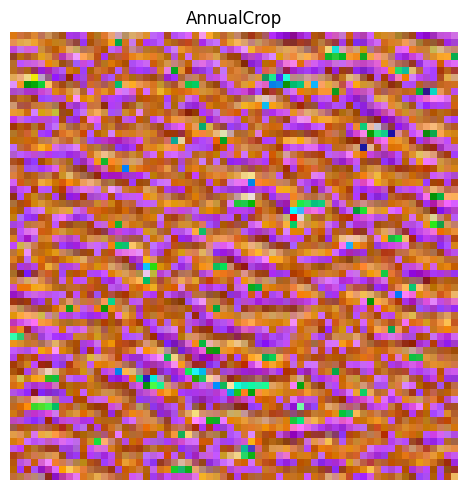

<Axes: ylabel='Count'>

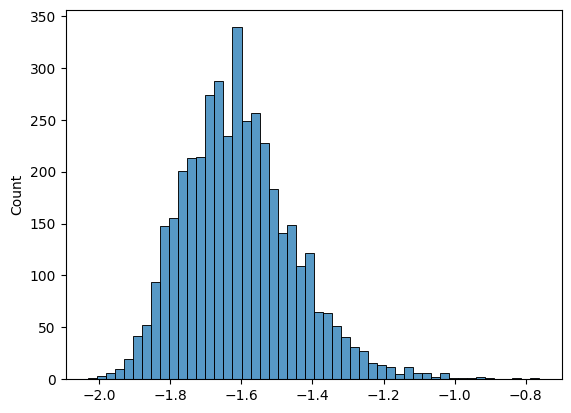

In [66]:
import seaborn as sns

img = test_dataset.__getitem__(300)[0]
print_image(img, {"ID":"Test"})

sns.histplot(img[2].flatten())


### Dataloaders

In [54]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import torch


train_dataset_subset, val_dataset_subset = random_split(train_dataset, [.8, .2])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)



## Utils

In [60]:
# Utility function to display image from dataset
# from rasterio.plot import reshape_as_image

def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    # print(lower_perc)
    # print(upper_perc)
    return (band_data - lower_perc) / (upper_perc - lower_perc)


def print_image(img, label, rgb_bands=[3,2,1])-> None:
  """Displays an image. Indices of bands given by "rgb_bands" will be displayed as RGB in the print
  """
  img = img.numpy()
  img = img.transpose(1,2,0)
  # img = normalize_for_display(img)
  img = img[:, :, rgb_bands]
  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)

  label = oh2text(label["ID"])
  ax.set_title(label)
  ax.axis(False)
  plt.tight_layout()

  plt.show()

[22.21538353  5.90259743  3.15957427  0.64028764  3.13157892  2.67949433
  2.2054826   0.90338994  2.3324703   6.6060605   2.72751331  1.00627069]
[25.12307549  8.18246737  5.59042597  3.62230253  5.96096506  6.13005648
  5.48508773  4.16195869  5.43446202  9.99090881  5.61428533  5.03630352]


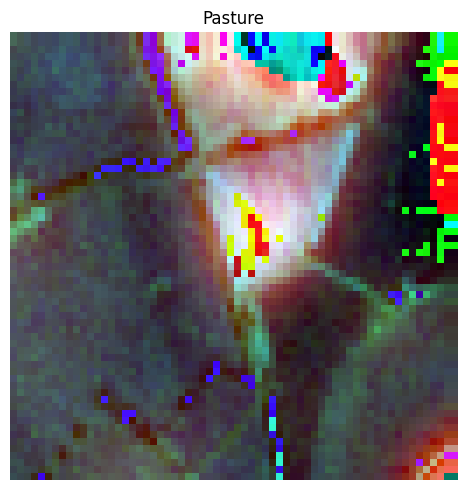

In [12]:
# # example image from test
# img, label = train_dataset.__getitem__(800)
# print_image(img, label, [0,1,2])
# # img.shape
# # 

# Model

In [2]:
!pip install transformers

     ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
     -------- ---------------------------- 30.7/134.8 kB 660.6 kB/s eta 0:00:01
     ---------------- -------------------- 61.4/134.8 kB 812.7 kB/s eta 0:00:01
     ------------------------------ ----- 112.6/134.8 kB 726.2 kB/s eta 0:00:01
     ------------------------------------ 134.8/134.8 kB 798.7 kB/s eta 0:00:00
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     -------------------------------------  41.0/42.0 kB 960.0 kB/s eta 0:00:01
     -------------------------------------- 42.0/42.0 kB 675.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB 991.0 kB/s eta 0:00:09
    --------------------------------------- 0.1/8.8 MB 1.3 MB/s eta 0:00:07
    --------------------------------------- 0.1/8.8 MB 1.2 MB/s eta 0:00:08
   - -------------------------------------- 0.2/8.8 MB 1.4 MB/s eta 0:00:07


In [4]:
from transformers import ViTForImageClassification, ViTConfig


model = ViTForImageClassification(ViTConfig(
    patch_size=6,
    num_labels=10,
    image_size=64,
    num_channels=12
)).to("cuda")

# Number of trainable parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

85474570

Load previous Model

In [ ]:
# model = model.load_state_dict(torch.load("04162024-143828.pt"))

# Train

In [ ]:
# https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/cifar10-baseline.html
class LitViT(L.LightningModule):
    def __init__(self, model):
        super().__init__()

        self.save_hyperparameters()
        self.model = model

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss
    
    # def evaluate(self, batch, stage=None):
    #     x, y = batch
    #     logits = self(x)
    #     loss = F.nll_loss(logits, y)
    #     preds = torch.argmax(logits, dim=1)
    #     acc = accuracy(preds, y)

    #     if stage:
    #         self.log(f"{stage}_loss", loss, prog_bar=True)
    #         self.log(f"{stage}_acc", acc, prog_bar=True)

    # def validation_step(self, batch, batch_idx):
    #     self.evaluate(batch, "val")

    # def test_step(self, batch, batch_idx):
    #     self.evaluate(batch, "test")

    # def configure_optimizers(self):
    #     optimizer = torch.optim.SGD(
    #         self.parameters(),
    #         lr=self.hparams.lr,
    #         momentum=0.9,
    #         weight_decay=5e-4,
    #     )
    #     steps_per_epoch = 45000 // BATCH_SIZE
    #     scheduler_dict = {
    #         "scheduler": OneCycleLR(
    #             optimizer,
    #             0.1,
    #             epochs=self.trainer.max_epochs,
    #             steps_per_epoch=steps_per_epoch,
    #         ),
    #         "interval": "step",
    #     }
    #     return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


    #     def training_step(self, batch, batch_idx):
    #     # training_step defines the train loop.
    #     # it is independent of forward
    #     x, y = batch
    #     x = x.view(x.size(0), -1)
    #     z = self.encoder(x)
    #     x_hat = self.decoder(z)
    #     loss = nn.functional.mse_loss(x_hat, x)
    #     # Logging to TensorBoard (if installed) by default
    #     self.log("train_loss", loss)
    #     return loss

    # def configure_optimizers(self):
    #     optimizer = optim.Adam(self.parameters(), lr=1e-3)
    #     return optimizer

In [ ]:
from datetime import datetime

execution_start = datetime.now().strftime("%m%d%Y-%H%M%S")

In [15]:
from torch import nn
train_losses = []
train_epoch_losses = []


model.train()

num_epochs = 18
mini_batch_size = 64

cross_entropy = nn.CrossEntropyLoss()

from torch import optim
learning_rate = 0.002
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for epoch in range(num_epochs):
    train_mini_batch_losses = []
    moving_avg_loss = 0.0
    
    for x, y_dict in (pbar := tqdm(train_dataloader)):

        pbar.set_description(f"{moving_avg_loss: .3f}")
        x = x.float().to(device)
        y = y_dict['ID'].to(device)


        outputs = model(x)

        loss = cross_entropy(outputs.logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store and log mini-batch losses
        train_mini_batch_losses.append(loss.item())
        train_losses.append(loss.item())
        moving_avg_loss = np.mean(train_losses[-5:])
        # print(f"Epoch {epoch}, Batch loss: {loss.item()}")
    else:
        epoch_loss = np.mean(train_mini_batch_losses)
        pbar.set_description(f"{epoch_loss: .3f}")

    # Average loss for the epoch
    
    train_epoch_losses.append(epoch_loss)
    
    if epoch_loss < .75:
        break


# Save final model



torch.save(model.state_dict(), f"{execution_start}.pt")

 0.000:   0%|                                                                                                                                                                                                                                                         | 0/422 [00:00<?, ?it/s]

 1.244: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:13<00:00,  3.17it/s]


Epoch 0 completed. Mean loss: 1.1906276663296294


 0.953: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.26it/s]


Epoch 1 completed. Mean loss: 1.0155915686416497


 0.808: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.25it/s]


Epoch 2 completed. Mean loss: 1.0335247000487664


 1.514: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:06<00:00,  3.32it/s]


Epoch 3 completed. Mean loss: 1.060868189730728


 0.965: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:08<00:00,  3.28it/s]


Epoch 4 completed. Mean loss: 1.1079406670320966


 0.952: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.26it/s]


Epoch 5 completed. Mean loss: 0.9323215078911319


 1.143: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.26it/s]


Epoch 6 completed. Mean loss: 0.968075693963032


 0.800: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:10<00:00,  3.23it/s]


Epoch 7 completed. Mean loss: 0.9646669674938635


 0.822: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.25it/s]


Epoch 8 completed. Mean loss: 0.9732726761129756


 0.984: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:10<00:00,  3.23it/s]


Epoch 9 completed. Mean loss: 1.0129237420048989


 0.897: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:11<00:00,  3.21it/s]


Epoch 10 completed. Mean loss: 0.9551650527578549


 1.027: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:13<00:00,  3.16it/s]


Epoch 11 completed. Mean loss: 0.9534264262711036


 0.844: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:12<00:00,  3.18it/s]


Epoch 12 completed. Mean loss: 0.9227740739907687


 0.982: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.26it/s]


Epoch 13 completed. Mean loss: 0.9451743291982894


 0.896: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:10<00:00,  3.24it/s]


Epoch 14 completed. Mean loss: 0.8280579302949546


 0.954: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:09<00:00,  3.26it/s]


Epoch 15 completed. Mean loss: 0.8761097559961875


 1.238: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:13<00:00,  3.16it/s]


Epoch 16 completed. Mean loss: 0.9218836981992563


 0.931: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [02:08<00:00,  3.29it/s]


Epoch 17 completed. Mean loss: 1.0085261428406047


[None]

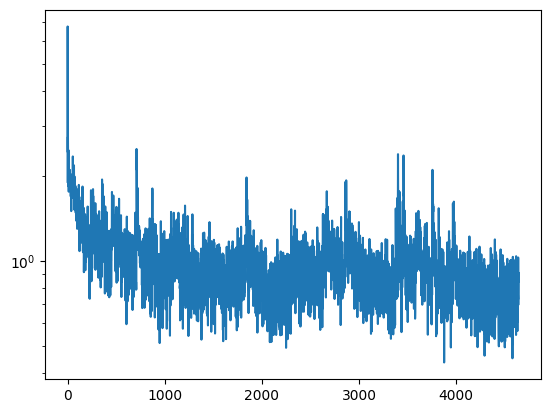

In [ ]:
import seaborn as sns


p = sns.lineplot(train_losses)
p.set(yscale='log')

# Validation

In [ ]:
# set model in evaluation mode
model.eval()


validate = []
for i, (imgs, labels) in enumerate(val_dataloader):
    preds = model(imgs.to("cuda")).logits
    pred_labels = [oh2text(oh.detach().cpu()) for oh in preds]
    validate += list(zip(labels, preds))


# TODO: Test Metrics

# Test

evaluation loop

In [ ]:
model.eval()

classArray = []

for i, (imgs, paths) in enumerate(test_dataloader):

    img_ids = [get_id(path) for path in paths]
    preds = model(imgs.to("cuda"))
    preds = list(preds.logits.detach())
    preds = [oh2text(pred.detach().cpu()) for pred in preds]
    classArray += list(zip(img_ids, preds))


## Submission





In [ ]:
import csv

with open(f'{execution_start}.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['test_id', 'label'])

    # Write each string to a row with its corresponding index as the test_id
    for i, label in classArray:
        writer.writerow([i, label])